In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Exotic option

Consider an exotic option whose payoff at maturity $T$ is given by 

$$h(S_t) = \left\{ \begin{array}{cc} \max\{S_T - K_1,\, 0\} & S_{T/2} \leq L \\ \max\{S_T - K_2,\, 0\} & S_{T/2} > L \end{array} \right.$$

In other words, the strike price depends on the value of the asset halfway to maturity.  We can also write this as 

$$h(S_t) = \max\{S_T - K_1,\, 0\}1_{(-\infty, L]}(S_{T/2}) + \max\{S_T - K_2,\, 0\}1_{(L, \infty)}(S_{T/2})$$

We want to estimate the value of our option at time 0: 

$$C = \mathbb{E}\left[e^{-rT}h(S_t)\right]$$

Using the direct approach, we could just simulate $S_t$ many times and then use it to calculate $e^{-rT}h(S_t)$ and average our results.  

Direct method: 
Expected value = 6.71251
Confidence interval = [6.42625, 6.99878]
Error bar size = 0.28627


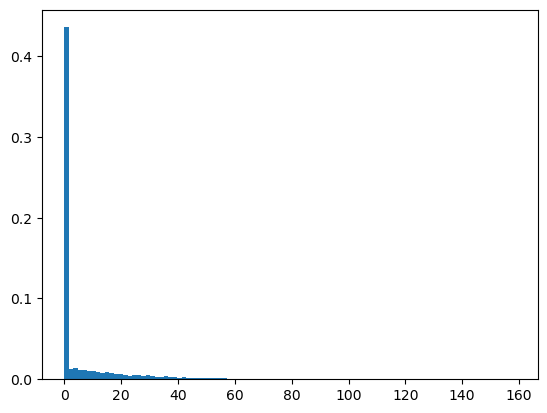

In [2]:
r = 0.05 
sigma = 0.4 
S0 = 100
K1 = 100 
K2 = 120 
L = 100 
T = 0.5

n = 10000
x = np.zeros(n)
s = np.zeros(3)
s[0] = S0

for k in range(n):
    z = np.random.randn(2)
    for i in range(len(s) - 1):
        s[i + 1] = s[i] * np.exp((r - sigma ** 2 / 2) * (T / 2) + sigma * np.sqrt(T / 2) * z[i])
    if s[1] <= L:
        x[k] = np.exp(-r * T) * np.max([s[2] - K1, 0])
    else:
        x[k] = np.exp(-r * T) * np.max([s[2] - K2, 0])
        
call_value = np.mean(x)
err = 1.96 * np.std(x) / np.sqrt(n)
lb, ub = call_value - err, call_value + err

print("Direct method: ")
print("Expected value = {:.5f}".format(call_value))
print("Confidence interval = [{:.5f}, {:.5f}]".format(lb, ub))
print("Error bar size = {:.5f}".format(err))

plt.hist(x, 100, density=True)
plt.show()

However, a natural choice for a condition presents itself.  The payoff function depends on $S_{T/2}$, and so it seems like a potentially good idea to condition on this variable.  We have 

$$\begin{aligned}
C &= \mathbb{E}\left[\mathbb{E}\left[e^{-rT}h(S_t)\:\vert\: S_{T/2}\right]\right] \\
&= \mathbb{E}\left[\mathbb{E}\left[e^{-rT}\left(\max\{S_T - K_1,\, 0\}1_{(-\infty, L]}(S_{T/2}) + \max\{S_T - K_2,\, 0\}1_{(L, \infty)}(S_{T/2})\right)\:\vert\: S_{T/2}\right]\right] \\
&= \mathbb{E}\left[1_{(-\infty, L]}(S_{T/2})\mathbb{E}\left[e^{-rT}\max\{S_T - K_1,\, 0\}\:\vert\: S_{T/2}\right]\right] \\
&\hspace{0.3in} + \mathbb{E}\left[1_{(L, \infty)}(S_{T/2})\mathbb{E}\left[e^{-rT}\max\{S_T - K_2,\, 0\}\:\vert\: S_{T/2}\right]\right]
\end{aligned}$$

$$\begin{aligned}
C &= \mathbb{E}\left[1_{(-\infty, L]}(S_{T/2})\mathbb{E}\left[e^{-rT}\max\{S_T - K_1,\, 0\}\:\vert\: S_{T/2}\right]\right] \\
&\hspace{0.3in} + \mathbb{E}\left[1_{(L, \infty)}(S_{T/2})\mathbb{E}\left[e^{-rT}\max\{S_T - K_2,\, 0\}\:\vert\: S_{T/2}\right]\right] \\
&= \mathbb{E}\left[e^{-rT/2}1_{(-\infty, L]}(S_{T/2})\mathbb{E}\left[e^{-r(T - T/2)}\max\{S_T - K_1,\, 0\}\:\vert\: S_{T/2}\right]\right] \\
&\hspace{0.3in} + \mathbb{E}\left[e^{-rT/2}1_{(L, \infty)}(S_{T/2})\mathbb{E}\left[e^{-r(T - T/2)}\max\{S_T - K_2,\, 0\}\:\vert\: S_{T/2}\right]\right] \\
&= \mathbb{E}\left[e^{-rT/2}1_{(-\infty, L]}(S_{T/2})C_{BS}(T/2, S_{T/2}, r, \sigma, T, K_1)\right] \\
&\hspace{0.3in} + \mathbb{E}\left[e^{-rT/2}1_{(L, \infty)}(S_{T/2})C_{BS}(T/2, S_{T/2}, r, \sigma, T, K_2)\right]
\end{aligned}$$

where $C_{BS}$ is the Black-Scholes formula for a vanilla European call option given by 

$$C_{BS}(t, S, r, \sigma, t, K) = S\Phi(d_1) - Ke^{-r(T - t)}\Phi(d_2)$$

and 

$$\begin{aligned}
d_1 &= \frac{\ln(S/K) + (r + \sigma^2 / 2)(T - t)}{\sigma\sqrt{T - t}} \\
d_2 &= d_1 - \sigma\sqrt{T - t}
\end{aligned}$$

and $\Phi$ is the cdf of the standard normal distribution.  

This means that we only need to simulate $S_{T/2}$ and then apply the Black-Scholes formula with the appropriate strike price. 

Conditional method: 
Expected value = 6.70981
Confidence interval = [6.55620, 6.86342]
Error bar size = 0.15361


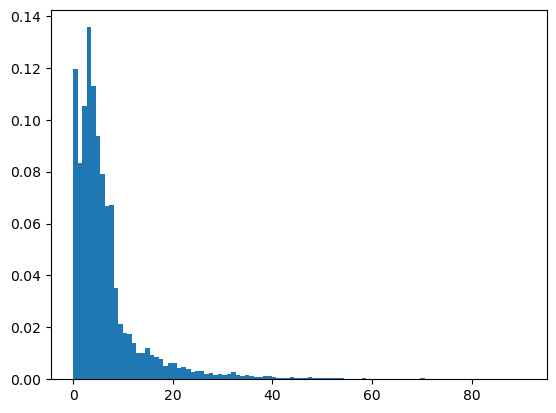

Error reduction = 46.34138%


In [4]:
from scipy.stats import norm
def cbs(t, S, r, sigma, T, K):
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)

r = 0.05 
sigma = 0.4 
S0 = 100
K1 = 100 
K2 = 120 
L = 100 
T = 0.5

n = 10000
x = np.zeros(n)

for k in range(n):
    z = np.random.randn()
    St2 = S0 * np.exp((r - sigma ** 2 / 2) * (T / 2) + sigma * np.sqrt(T / 2) * z)
    if St2 <= L:
        x[k] = np.exp(-r * T / 2) * cbs(T / 2, St2, r, sigma, T, K1)
    else:
        x[k] = np.exp(-r * T / 2) * cbs(T / 2, St2, r, sigma, T, K2)
        
call_value = np.mean(x)
err_cond = 1.96 * np.std(x) / np.sqrt(n)
lb, ub = call_value - err_cond, call_value + err_cond

print("Conditional method: ")
print("Expected value = {:.5f}".format(call_value))
print("Confidence interval = [{:.5f}, {:.5f}]".format(lb, ub))
print("Error bar size = {:.5f}".format(err_cond))

plt.hist(x, 100, density=True)
plt.show()

print("Error reduction = {:.5f}%".format(100 * (1 - err_cond / err)))